<a href="https://colab.research.google.com/github/infiniteoverflow/Simple-RNN/blob/master/Simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from torch import nn
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt


# Defining the dataset

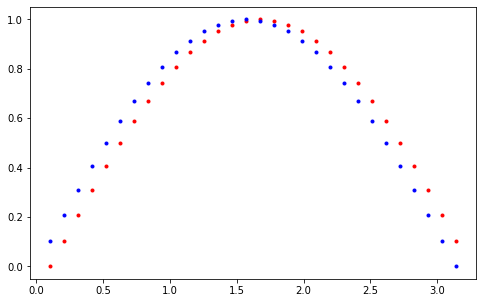

In [7]:
plt.figure(figsize=(8,5))

seq_length = 30

time_series = np.linspace(0,np.pi,num=seq_length+1)
data = np.sin(time_series)

data.resize((seq_length+1 , 1))

x = data[:-1]
y = data[1:]

plt.plot(time_series[1:], x, 'r.', label='input, x') # x
plt.plot(time_series[1:], y, 'b.', label='target, y') # y

plt.show()